In [1]:
import sys
from os import path as osp
from datetime import datetime
from tqdm import tqdm
from skimage import io, transform
from matplotlib import pyplot as plt
import numpy as np

# torch imports
import torch
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader

# root path of project
from os import path as osp
import sys

# get root directory
import re
reg = '^.*/AquaPose'
project_root = re.findall(reg, osp.dirname(osp.abspath(sys.argv[0])))[0]
sys.path.append(project_root)

from lib.dataset.PoseDataset import PoseDataset
from lib.dataset.custom_transforms import DictToTensor
from lib.models.keypoint_rcnn import get_resnet50_pretrained_model

from lib.utils.visual_utils import *
from lib.matching.matching import *


In [2]:
from glob import glob

model = get_resnet50_pretrained_model()
weight_dir = osp.join(project_root, 'weights')

weight_files = glob(osp.join(weight_dir,'*'))
for file in weight_files:
    print(file +'\n')

['/mnt/c/Users/Vande/OneDrive - ugentbe/Ingenieurswetenschappen/_master/thesis/AquaPose/weights/6_freestyle_ds_20-03-2020-10-00_epoch39-40.wth', '/mnt/c/Users/Vande/OneDrive - ugentbe/Ingenieurswetenschappen/_master/thesis/AquaPose/weights/ds_1_2_3_4_25-03-2020-16-48_epoch59-60_min_val_loss_10000.wth', '/mnt/c/Users/Vande/OneDrive - ugentbe/Ingenieurswetenschappen/_master/thesis/AquaPose/weights/weights_4_box_and_key_predictor.wth', '/mnt/c/Users/Vande/OneDrive - ugentbe/Ingenieurswetenschappen/_master/thesis/AquaPose/weights/weights_4_epoch.wth', '/mnt/c/Users/Vande/OneDrive - ugentbe/Ingenieurswetenschappen/_master/thesis/AquaPose/weights/weights_4_finally_fixed.wth', '/mnt/c/Users/Vande/OneDrive - ugentbe/Ingenieurswetenschappen/_master/thesis/AquaPose/weights/weights_4_finally_fixed_interrupted.wth', '/mnt/c/Users/Vande/OneDrive - ugentbe/Ingenieurswetenschappen/_master/thesis/AquaPose/weights/weights_4_only_box.wth', '/mnt/c/Users/Vande/OneDrive - ugentbe/Ingenieurswetenschappen/_

In [3]:
model.load_state_dict(torch.load(weight_files[1], map_location=torch.device('cpu')))

#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')



<All keys matched successfully>

In [27]:
annotation_keypoints = {
            '0': "Nose",
            '1': "left_eye",
            '2': "right_eye",
            '3': "left_ear",
            '4': "right_ear",
            '5': "Shoulder_Close",
            '6': "Shoulder_Far",
            '7': "Elbow_Close",
            '8': "Elbow_Far",
            '9': "Wrist_Close",
            '10': "Wrist_Far",
            '11': "Hip_Close",
            '12': "Hip_Far",
            '13': "Knee_Close",
            '14': "Knee_Far",
            '15': "Ankle_Close",
            '16': "Ankle_Far",
}

In [28]:
demo_dir = osp.join(project_root, 'demo_data')
image_files = glob(osp.join(demo_dir, '*'))



In [31]:
image = io.imread(image_files[6])
image_tensor = transforms.ToTensor()(image)
model.eval()
prediction = model([image_tensor])

1
0.982205331325531


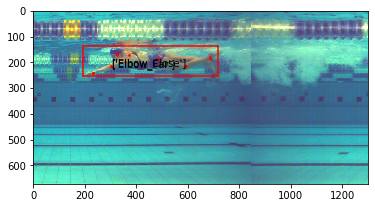

In [41]:
keypoints_scores = prediction[0]['keypoints_scores']
boxes = prediction[0]['boxes']
labels = prediction[0]['labels']
scores = prediction[0]['scores']
keypoints = prediction[0]['keypoints']

fig, ax = plt.subplots()

plt.imshow(image_tensor.permute(1,2,0).detach().numpy())
max_score = 0
max_box = []
for idx, box in enumerate(boxes):
    if scores[idx].item() > max_score:
        print(labels[idx].data.numpy())
        max_score = scores[idx].item()
        max_box = box
        max_keypoints = keypoints[idx] 
        max_keypoints_scores = keypoints_scores[idx]
print(max_score)
#for box in boxes[np.where(scores > .80)]:
#print(max_keypoints[np.argwhere(max_keypoints_scores > 1)])
for box in [max_box]:
    # add keypoints to imag
        # TODO: add color coding for different body parts
        
        # draw lines as specified in skeleton 
    
    plt.plot([box[0], box[2]], [box[1], box[1]], c='r')
    plt.plot([box[0], box[2]], [box[3], box[3]], c='r')
    plt.plot([box[0], box[0]], [box[1], box[3]], c='r')
    plt.plot([box[2], box[2]], [box[1], box[3]], c='r')

    min_keypoint_score = 1


    keypoints_min_score = max_keypoints[[np.argwhere(max_keypoints_scores.detach().numpy() > min_keypoint_score)]].detach().numpy()
    annotations_min_score = np.array(list(annotation_keypoints.values()))[[np.argwhere(max_keypoints_scores.detach().numpy() > min_keypoint_score)]]

    # print(max_keypoints_scores.detach().numpy())
    # print([np.argwhere(max_keypoints_scores.detach().numpy() > 5)])
    # print(max_keypoints[[np.argwhere(max_keypoints_scores.detach().numpy() > 5)]].detach().numpy())
    ax.scatter(np.array(keypoints_min_score)[:,0,0],np.array(keypoints_min_score)[:,0,1], s=10, marker='.', c='r')

    # annotate points on image
    for i, annotation in enumerate(annotations_min_score):
        if "Elbow" in annotation[0]:
            ax.annotate(annotation, (np.array(keypoints_min_score)[i,0,0], np.array(keypoints_min_score)[i,0,1]))

        # pause a bit so that plots are updated
plt.pause(0.001)  
        
        # display
plt.show(block=True)